# CNN Architectures

## Librairies

In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score, classification_report


import tensorflow as tf
print("Tensorflow:",tf.__version__)
print("GPU list:",tf.config.list_physical_devices('GPU'))
from tensorflow.keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import Adam

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from IPython.display import Image


2024-06-08 22:02:47.318534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-08 22:02:47.342127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 22:02:47.684815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow: 2.16.1
GPU list: []


2024-06-08 22:02:47.923518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 22:02:47.926236: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Functions

In [2]:

def confusion_matrix_plot(y_true, y_pred, file_save="",labels=[], size=8, fz=15):
    
    cf_matrix = confusion_matrix(y_true, y_pred, normalize=("true"))
    cf_matrix_v = confusion_matrix(y_true, y_pred)
    
    if (len(labels)==0):
        labels = np.unique(y_true)
        print(labels)
    
    # Define a color map for the heatmap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    plt.figure(figsize = (size,size))
    heatmap = sns.heatmap(cf_matrix, annot=False, cmap=cmap, fmt='d', xticklabels=labels, yticklabels=labels, square=True, cbar=True)
    # heatmap = sns.heatmap(data, annot=False, fmt='d', cmap=cmap)
    
    # Calculate and display percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            text = f"{cf_matrix[i][j]*100: 0.2f}% ({cf_matrix_v[i][j]})"
            
            # Calculate the background color at the center of the cell
            cell_bg_color = np.mean(cmap(cf_matrix[i][j]))
            print(i,j, cell_bg_color)
            # Choose a text color based on the background color
            text_color = 'black' if cell_bg_color > 0.7 else 'white'
                    
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)
    
    # ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
    # ax.set_yticklabels(ax.get_xticklabels(),rotation = 40)
    

    plt.title("Confusion Matrix",fontsize=fz)
    plt.xlabel("Predicted",fontsize=fz-2)
    plt.ylabel("Real",fontsize=fz-2)
    
    plt.tight_layout()
    
    if(file_save!=""):
        plt.savefig(file_save)
    
    plt.show()
    
    return cf_matrix




def load_images_vgg16(db_path):

    ## List images from dataset ##
    image_file_list = os.listdir(db_path)

    ## Lists to save information ##
    img_list = []
    label_list = []

    for file in image_file_list:

        #### Load-pre-process-save images ####
        ## Create image file ##
        image_file = os.path.join(db_path, file)
        ## Load image ##
        img = cv2.imread(image_file)
        ## Tranform to gray sacale ##
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC) 
        ## Reshape the image to (W, H, C) ##
        # H, W = img.shape
        # img = img.reshape(W, H, 1)
        ## Normalize pixels to [0,1] ##
        # img = np.float64(img)/255.0
        ## Invert image pixels ##
        img = (255.0 - img)

        ## save image in list ##
        img_list.append(img)
        #######################################

        #### Assign labels ####
        if("PD_" in file):
            label_list.append(1)
        else:
            label_list.append(0)
        #######################

    ## Conver images to array object ##
    img_arr = np.asarray(img_list)
    img_arr = preprocess_input(img_arr)

    ## Conver label to array object ##
    label_arr = np.asarray(label_list)

    print(img_arr.shape, type(img_arr))
    print(label_arr.shape, type(label_arr))



    return img_arr, label_arr


def split_data_Train_Test(X, y):

    #### Codify labels to onehot ####
    num_classes = len(np.unique(y))
    

    #### Split Data ####
    ## Train and test ##
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    
    ## Convert labels to categorical ##
    y_train_c = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_c = tf.keras.utils.to_categorical(y_test, num_classes)


    values, counts = np.unique(y_train, return_counts=True)
    print(f"Train data {X_train.shape}, {y_train_c.shape}, {counts}")

    values, counts = np.unique(y_test, return_counts=True)
    print(f"Test data {X_test.shape}, {y_test_c.shape}, {counts}")

    idx = np.random.randint(0, len(y_train_c))
    print_image(X_train[idx], title=f"lab:{y_train_c[idx]}")

    return X_train, y_train_c, X_test, y_test_c



def print_image(img, title="Image"):
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()


def create_dir(path):

    dirs = path.split("/")
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 


# plot accuracy and loss
def plotgraph(epochs, train, val, ax, plot, title):
    # Plot training & validation accuracy values
    ax[plot].plot(epochs, train, 'b')
    ax[plot].plot(epochs, val, 'r')
    ax[plot].set_title(title)
    #ax[plot].ylabel(title)
    ax[plot].set(xlabel='Epoch', ylabel=title)
    #ax[plot].xlabel('Epoch')
    ax[plot].legend(['Train', 'Val'])
    

## Define parameters

In [6]:



#### Load data ####
task = "spiral"
dp = 0.4
lr = 1e-7
wd = 1e-4

epch = 2
pt = 1
md = 0.00001
bz = 6



pp = "../"
model_name = "prueba_VGG16"


## Load data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(130, 256, 256, 3) <class 'numpy.ndarray'>
(130,) <class 'numpy.ndarray'>
Train data (104, 256, 256, 3), (104, 2), [40 64]
Test data (26, 256, 256, 3), (26, 2), [15 11]


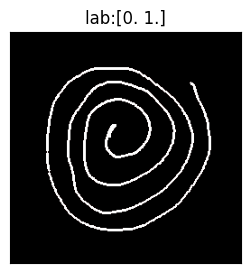

In [4]:

db_path = os.path.join(pp,f"hw_drawings", task)

X, y = load_images_vgg16(db_path)
# X_train, y_train_c, X_val, y_val_c, X_test, y_test_c = split_data(X, y)

X_train, y_train_c, X_test, y_test_c = split_data_Train_Test(X, y)


## Define model

### VGG16 model

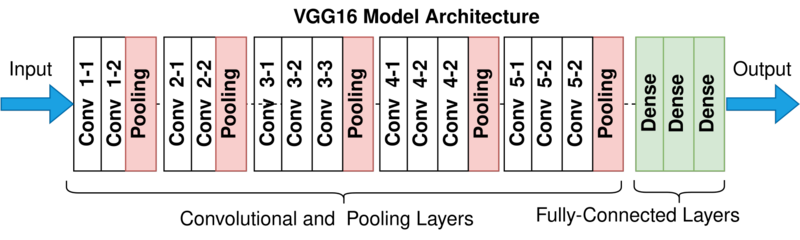

In [18]:
Image(filename='VGG16.png')

In [5]:



base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', name="dense")(x)
predictions = Dense(2, activation='softmax', name="prediction")(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
trainable_flag = False
#### Set up  VGG16 layers as trainable or not ####

block = 5
for layer in model.layers:
    if(f"block{block}_conv" in layer.name):
        trainable_flag = True
    
    print(layer.name, trainable_flag)
    layer.trainable = trainable_flag


#### Set up specific blocks as trainable ####
# conv_lavers = [layer for layer in base_model.layers if("block5_conv" in layer.name)]
# for layer in conv_lavers:
#     layer.trainable = True

for i, layer in enumerate(model.layers):
   print(i, layer.name)


# img_path = 'elephant.jpg'
# img = keras.utils.load_img(img_path, target_size=(224, 224))
# x = keras.utils.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# features = model.predict(x)

model.summary()

trainable_count = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_count = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])


print(trainable_count)
print(non_trainable_count)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True
dense True
prediction True
0 input_layer
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d
20 dense
21 prediction


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 7,145,346 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

7145346
7635264


## Train model

In [7]:


print("Model Training: ", model_name, "\n\n")

model_path = os.path.join(pp,"Models",task,model_name)
create_dir(model_path)

## Define model file ##
model_file = os.path.join(model_path, f"{model_name}_model.keras")
## Define log file
log_dir = os.path.join(model_path, f"fit/{model_name}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr, weight_decay=wd), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=md, patience=pt, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', verbose=1, mode='min')



tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train,
                    y_train_c,
                    epochs=epch,
                    batch_size=bz,
                    verbose=1,
                    validation_data=(X_test, y_test_c),
                    callbacks=[early_stopping, mcp_save, tensorboard_callback])



Model Training:  prueba_VGG16 


Epoch 1/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4415 - loss: 2.0288
Epoch 1: val_loss improved from inf to 1.07357, saving model to ../Models/spiral/prueba_VGG16/prueba_VGG16_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.4426 - loss: 2.0244 - val_accuracy: 0.6538 - val_loss: 1.0736
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4878 - loss: 1.8228
Epoch 2: val_loss improved from 1.07357 to 1.02196, saving model to ../Models/spiral/prueba_VGG16/prueba_VGG16_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.4865 - loss: 1.8232 - val_accuracy: 0.6923 - val_loss: 1.0220


## History

In [8]:

history_file = os.path.join(model_path, f"history_{model_name}.picl")
with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
file_pi.close()

In [9]:
# pp = "../"
# model_name = "Test_Fine_Tuned_VGG16"

model_path = os.path.join(pp,"Models",task,model_name)
history_file = os.path.join(model_path, f"history_{model_name}.picl")
with open(history_file, 'rb') as file_pi:
  history = pickle.load(file_pi)
file_pi.close()

pd.DataFrame.from_dict(history)

,accuracy,loss,val_accuracy,val_loss
0,0.461538,1.945187,0.653846,1.073574
1,0.461538,1.829726,0.692308,1.021964


## Training curves

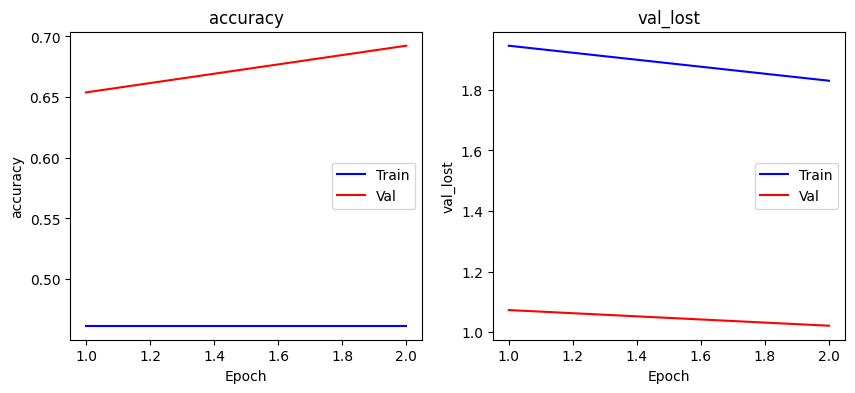

In [10]:

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1,len(acc)+1)


#### crear subplot ####
fig, ax = plt.subplots(1, 2, figsize=(10,4))
#### graficar curva acc ###
plotgraph(epochs, acc, val_acc, ax, 0, "accuracy")
#### graficar curva lost ###
plotgraph(epochs, loss, val_loss, ax, 1, "val_lost")

fig_file = os.path.join(model_path, f"history_{model_name}.pdf")
plt.savefig(fig_file)
plt.show()


## Test Model

In [11]:

model_file = os.path.join(model_path, f"{model_name}_model.keras")
print(model_file)

model = models.load_model(model_file)
model.summary()


../Models/spiral/prueba_VGG16/prueba_VGG16_model.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,071,304 (110.90 MB)

 Trainable params: 7,145,346 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,290,694 (54.51 MB)

In [12]:
model.evaluate(X_train, y_train_c)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - accuracy: 0.4294 - loss: 1.9095


[1.7715378999710083, 0.4615384638309479]

In [13]:
model.evaluate(X_test, y_test_c)
y_pred_c = model.predict(X_test)
y_pred = y_pred_c.argmax(axis=1)
y_true = y_test_c.argmax(axis=1)
print(y_true.shape, y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 0.6923 - loss: 1.0220
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
(26,) (26,)


## Report

In [14]:
#### Mostrar la microclasificación ####
label_dictionary = {
    0: "HC",
    1: "PD"

}
report = classification_report(y_true, y_pred, digits=4, output_dict=False, target_names=list(label_dictionary.values()))
table_report = classification_report(y_true, y_pred, digits=4, output_dict=True, target_names=list(label_dictionary.values()))
table_report = pd.DataFrame.from_dict(table_report).T
print(report)


              precision    recall  f1-score   support

          HC     0.6667    0.9333    0.7778        15
          PD     0.8000    0.3636    0.5000        11

    accuracy                         0.6923        26
   macro avg     0.7333    0.6485    0.6389        26
weighted avg     0.7231    0.6923    0.6603        26



## Confusion Matrix

0 0 0.4526797385620915
0 1 0.9626143790849673
1 0 0.6452595155709342
1 1 0.8292618223760093


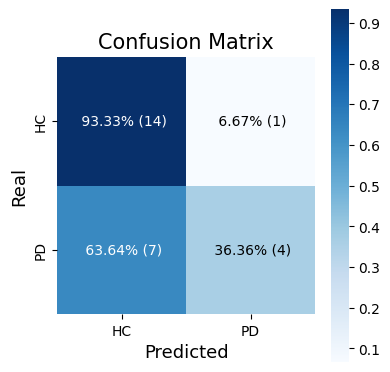

array([[0.93333333, 0.06666667],
       [0.63636364, 0.36363636]])

In [15]:
labels = list(label_dictionary.values())
cm_file_save = os.path.join(model_path, f"CM_{model_name}.pdf")
confusion_matrix_plot(y_true, y_pred, cm_file_save,labels=labels, size=4, fz=15)


# Save results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


alphabet
(126, 256, 256, 3) <class 'numpy.ndarray'>
(126,) <class 'numpy.ndarray'>
Train data (100, 256, 256, 3), (100, 2), [44 56]
Test data (26, 256, 256, 3), (26, 2), [11 15]


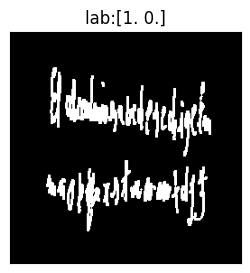

../Models/alphabet/Test_VGG16/Test_VGG16_model.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - accuracy: 0.6538 - loss: 0.6300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(26,) (26,)
freewriting
(127, 256, 256, 3) <class 'numpy.ndarray'>
(127,) <class 'numpy.ndarray'>
Train data (101, 256, 256, 3), (101, 2), [41 60]
Test data (26, 256, 256, 3), (26, 2), [13 13]


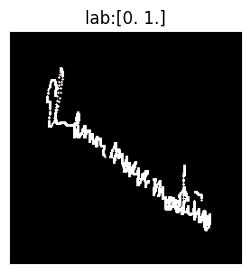

../Models/freewriting/Test_VGG16/Test_VGG16_model.keras


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step - accuracy: 0.2308 - loss: 1.2100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
(26,) (26,)
house
(130, 256, 256, 3) <class 'numpy.ndarray'>
(130,) <class 'numpy.ndarray'>
Train data (104, 256, 256, 3), (104, 2), [43 61]
Test data (26, 256, 256, 3), (26, 2), [12 14]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


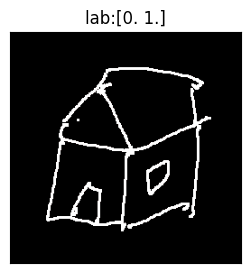

../Models/house/Test_VGG16/Test_VGG16_model.keras


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step - accuracy: 0.5769 - loss: 0.8804
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(26,) (26,)
line1
(102, 256, 256, 3) <class 'numpy.ndarray'>
(102,) <class 'numpy.ndarray'>
Train data (81, 256, 256, 3), (81, 2), [34 47]
Test data (21, 256, 256, 3), (21, 2), [ 8 13]


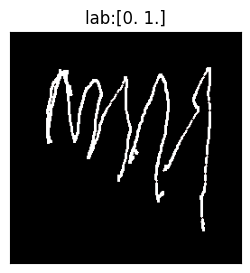

../Models/line1/Test_VGG16/Test_VGG16_model.keras


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - accuracy: 0.4286 - loss: 0.8264
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
(21,) (21,)
name
(129, 256, 256, 3) <class 'numpy.ndarray'>
(129,) <class 'numpy.ndarray'>
Train data (103, 256, 256, 3), (103, 2), [45 58]
Test data (26, 256, 256, 3), (26, 2), [10 16]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


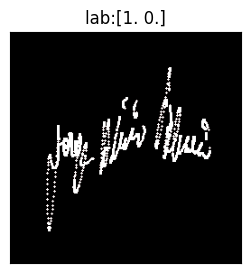

../Models/name/Test_VGG16/Test_VGG16_model.keras


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step - accuracy: 0.8462 - loss: 0.3442
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(26,) (26,)
rey
(123, 256, 256, 3) <class 'numpy.ndarray'>
(123,) <class 'numpy.ndarray'>
Train data (98, 256, 256, 3), (98, 2), [43 55]
Test data (25, 256, 256, 3), (25, 2), [11 14]


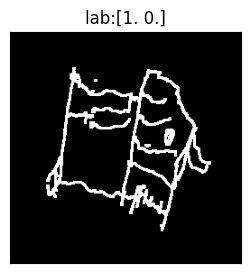

../Models/rey/Test_VGG16/Test_VGG16_model.keras


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step - accuracy: 0.7600 - loss: 0.5254
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(25,) (25,)
spiral
(130, 256, 256, 3) <class 'numpy.ndarray'>
(130,) <class 'numpy.ndarray'>
Train data (104, 256, 256, 3), (104, 2), [40 64]
Test data (26, 256, 256, 3), (26, 2), [15 11]


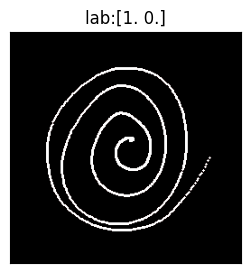

../Models/spiral/Test_VGG16/Test_VGG16_model.keras


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step - accuracy: 0.7692 - loss: 0.5082
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
(26,) (26,)


,Task,Accuracy,Balanced_Accuracy,Specificity,Sensitivity,F1_Score
0,name,84.615385,87.500000,100.000000,75.000000,0.857143
1,spiral,76.923077,75.151515,86.666667,63.636364,0.700000
2,rey,76.000000,74.675325,63.636364,85.714286,0.800000
3,alphabet,65.384615,63.939394,54.545455,73.333333,0.709677
4,house,57.692308,56.547619,41.666667,71.428571,0.645161
5,line1,42.857143,41.826923,37.500000,46.153846,0.500000
6,freewriting,23.076923,23.076923,23.076923,23.076923,0.230769


In [11]:
pp = "../"

# model_name = "Test_Fine_Tuned_VGG16"
model_name = "Test_VGG16"
result_file = os.path.join(pp, "Results", f"{model_name}.xlsx")

## Save info ##
task_list = []
acc_list = []
b_acc_list = []
sens_list = []
spec_list = []
f1_s_list = []

tk_list = ["alphabet", "freewriting", "house", "line1", "name", "rey", "spiral"]

for task in tk_list:
    
    print(task)

    db_path = os.path.join(pp,f"Dataset/hw_drawings", task)

    #### Load data ####
    X, y = load_images_vgg16(db_path)
    X_train, y_train_c, X_test, y_test_c = split_data_Train_Test(X, y)

    #### Load model ####
    model_path = os.path.join(pp,"Models",task,model_name)
    model_file = os.path.join(model_path, f"{model_name}_model.keras")
    print(model_file)

    model = models.load_model(model_file)
    model.summary()

    #### Make predictions ####
    model.evaluate(X_test, y_test_c)
    y_pred_c = model.predict(X_test)
    y_pred = y_pred_c.argmax(axis=1)
    y_true = y_test_c.argmax(axis=1)
    print(y_true.shape, y_pred.shape)

    ##  Evaluate metrics ##
    acc = accuracy_score(y_true, y_pred)*100
    b_acc = balanced_accuracy_score(y_true, y_pred)*100
    sens = recall_score(y_true, y_pred)*100
    ## Specificity ##
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn/(tn+fp)*100
    f1_s = f1_score(y_true, y_pred)


    #### Save info ####
    task_list.append(task)
    acc_list.append(acc)
    b_acc_list.append(b_acc)
    sens_list.append(sens)
    spec_list.append(spec)
    f1_s_list.append(f1_s)

    # break



result_df = pd.DataFrame([])
result_df["Task"] = task_list
result_df["Accuracy"] = acc_list
result_df["Balanced_Accuracy"] = b_acc_list
result_df["Specificity"] = spec_list
result_df["Sensitivity"] = sens_list
result_df["F1_Score"] = f1_s_list


result_df.sort_values(by="Accuracy", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)
result_df.to_excel(result_file, index=False)
result_df


# Fin